In [1]:
%matplotlib inline

import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
import time

plt.style.use(style="seaborn")
# plt.rcParams['figure.dpi'] = 400
sns.set_style('whitegrid')


In [2]:
ticker_list = ["aapl", "amzn", "msft"]

ticker = ticker_list[2]

ticker_upper = ticker.upper()

print("Ticker:", ticker_upper)


################################################


source_list = ["BENZINGA", "TWINT"]

source = source_list[0]

print("Source:", source)


################################################


model_type_list = ["arima"]

model_type = model_type_list[0]

print("Model Type:", model_type.upper())


################################################


if ticker == "aapl":
    p, d, q = 17,1,20

elif ticker == "amzn":
    p, d, q, = 9,1,9

elif ticker == "msft":
    p, d, q = 12,1,13


################################################

print("p:", p, "\nd:", d, "\nq:", q)

################################################

scale_values = False

print("Scale Values:", scale_values)



Ticker: MSFT
Source: BENZINGA
Model Type: ARIMA
p: 12 
d: 1 
q: 13
Scale Values: False


In [3]:
csv_path = f"/app/StockPricePredictions/data/alphavantage/time_series_daily_adjusted/{ticker_upper}/{ticker_upper}_WITH_{source}_FINBERT_SA.csv"

In [4]:
df = pd.read_csv(csv_path)
df.sort_values(by=["date"], ascending=True, inplace=True)
df.reset_index(drop=True, inplace=True)

date_time = pd.to_datetime(df.pop('date'))

df = df[["5. adjusted close"]].copy()

df.index = date_time

In [5]:
 if scale_values:
    
    from sklearn.preprocessing import MinMaxScaler

    X = df.values
    scaler = MinMaxScaler(feature_range=(0, 1)).fit(X)
    X_scaled = scaler.transform(X)
    df["5. adjusted close"] = [x[0] for x in X_scaled]

In [6]:
split_time = int(len(df) * .9)

train_df = df[:split_time]
test_df = df[split_time:]

print(len(train_df))
print(len(test_df))

df = test_df[["5. adjusted close"]].copy()

2757
307


In [7]:
df.describe()

,5. adjusted close
count,307.000000
mean,276.163919
std,37.300208
min,210.051892
25%,242.339020
50%,282.417959
75%,302.217360
max,342.401190


In [8]:
df.head()

,5. adjusted close
date,
2020-12-15,211.912422
2020-12-16,217.009088
2020-12-17,217.147638
2020-12-18,216.326234
2020-12-21,220.284809


### Check if the time series is stationary

In [9]:
from statsmodels.tsa.stattools import adfuller

result = adfuller(df["5. adjusted close"])
print(f"ADF Statistic: {result[0]}")
print(f"p-value: {result[1]}")

ADF Statistic: -1.6999661731484106
p-value: 0.43112990556462827


#### Autocorrelation Function (ACF)

In [10]:
from statsmodels.graphics.tsaplots import plot_acf

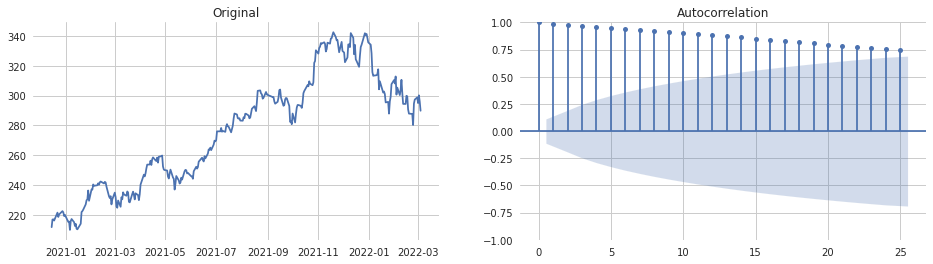

In [11]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16,4))

ax1.plot(df["5. adjusted close"])
ax1.set_title("Original")
plot_acf(df["5. adjusted close"], ax=ax2);

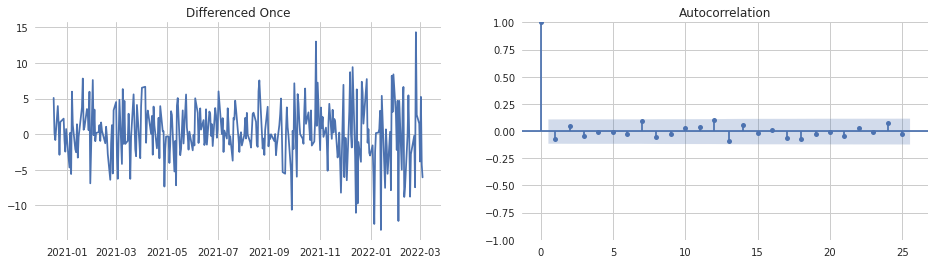

In [12]:
diff = df["5. adjusted close"].diff().dropna()

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16,4))

ax1.plot(diff)
ax1.set_title("Differenced Once")
plot_acf(diff, ax=ax2);

In [13]:
# pip install pmdarima
from pmdarima.arima.utils import ndiffs

In [14]:
ndiffs(df["5. adjusted close"])

1

__p__

p is the order of the Auto Regressive (AR) term.  It refers to the number of lags to be used as predictors.

We can find out the required number of AR terms by inspecting the Partial Autocorrelation (PACF) plot.

The partial autocorrelation represents the correlation between the series and its lags.

In [15]:
from statsmodels.graphics.tsaplots import plot_pacf

/usr/local/lib/python3.8/dist-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


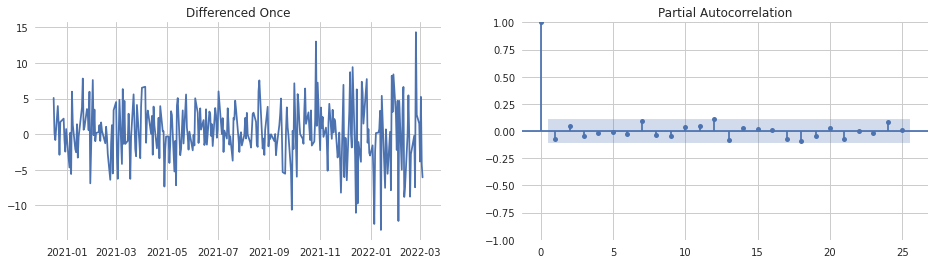

In [16]:
diff = df["5. adjusted close"].diff().dropna()

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16,4))

ax1.plot(diff)
ax1.set_title("Differenced Once")
plot_pacf(diff, ax=ax2);

__q__

q is the order of the Moving Average (MA) term.  It refers to the number of lagged forecast errors that should go into the ARIMA Model.

We can look at the ACF plot for the number of MA terms.



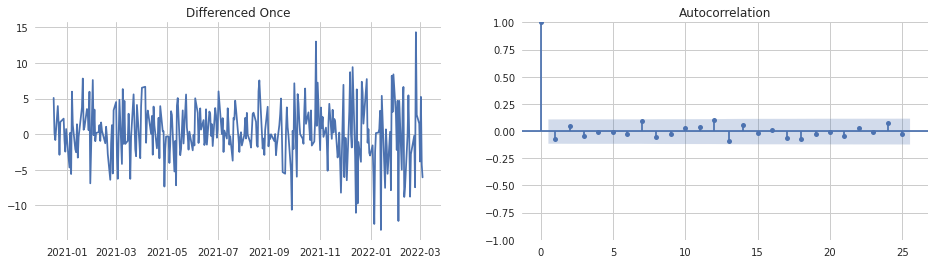

In [17]:
diff = df["5. adjusted close"].diff().dropna()

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16,4))

ax1.plot(diff)
ax1.set_title("Differenced Once")
plot_acf(diff, ax=ax2);

#### Fitting the ARIMA Model

In [18]:
from statsmodels.tsa.arima.model import ARIMA
# from statsmodels.tsa.arima_model import ARIMA

model = ARIMA(df["5. adjusted close"], order=(p, d, q))
result = model.fit()


/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/l

In [19]:
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:      5. adjusted close   No. Observations:                  307
Model:               ARIMA(12, 1, 13)   Log Likelihood                -845.051
Date:                Thu, 14 Jul 2022   AIC                           1742.103
Time:                        04:10:27   BIC                           1838.916
Sample:                             0   HQIC                          1780.822
                                - 307                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.6728      1.078     -0.624      0.532      -2.785       1.439
ar.L2          0.0926      1.027      0.090      0.928      -1.920       2.105
ar.L3         -0.0015      0.587     -0.003      0.998      -1.151       1.148
ar.L4         -0.1343      0.564     -0.238      0.812      -1.241       0.972
ar.L5          0.1011      0.503      0.201      0.841      -0.886       1.088
ar.L6          0.0368      0.554      0.066      0.947      -1.049       1.123
ar.L7         -0.1192      0.476     -0.250      0.802      -1.053       0.814
ar.L8          0.0845      0.593      0.142      0.887      -1.078       1.247
ar.L9         -0.0505      0.388     -0.130      0.896      -0.811       0.710
ar.L10        -0.4451      0.362     -1.228      0.219      -1.155       0.265
ar.L11        -0.4163      0.694     -0.600      0.548      -1.776       0.943
ar.L12        -0.3642      0.517     -0.704      0.482      -1.378       0.650
ma.L1          0.6115      1.210      0.505      0.613      -1.761       2.984
ma.L2         -0.0387      1.625     -0.024      0.981      -3.223       3.145
ma.L3          0.0512      1.304      0.039      0.969      -2.506       2.608
ma.L4          0.0385      0.965      0.040      0.968      -1.854       1.931
ma.L5         -0.2075      0.901     -0.230      0.818      -1.973       1.558
ma.L6         -0.0021      0.765     -0.003      0.998      -1.502       1.498
ma.L7          0.3154      1.094      0.288      0.773      -1.828       2.459
ma.L8         -0.0692      1.180     -0.059      0.953      -2.381       2.243
ma.L9         -0.0136      1.310     -0.010      0.992      -2.581       2.553
ma.L10         0.5003      1.130      0.443      0.658      -1.714       2.715
ma.L11         0.5702      1.353      0.421      0.673      -2.082       3.222
ma.L12         0.5267      0.941      0.560      0.576      -1.317       2.371
ma.L13        -0.0582      0.177     -0.329      0.742      -0.405       0.288
sigma2        14.3991     15.500      0.929      0.353     -15.981      44.779
===================================================================================
Ljung-Box (L1) (Q):                   0.01   Jarque-Bera (JB):                14.74
Prob(Q):                              0.94   Prob(JB):                         0.00
Heteroskedasticity (H):               2.24   Skew:                            -0.33
Prob(H) (two-sided):                  0.00   Kurtosis:                         3.85
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [20]:
# Actual vs. Fitted

# result.plot_diagnostics()
len(result.forecasts[0])

307

In [21]:
df["preds"] = result.forecasts[0]

In [22]:
df.head()

,5. adjusted close,preds
date,,
2020-12-15,211.912422,0.000000
2020-12-16,217.009088,211.912199
2020-12-17,217.147638,216.685390
2020-12-18,216.326234,217.454416
2020-12-21,220.284809,216.278558


In [23]:
result.forecasts[0][-306:]

array([211.91219933, 216.68539016, 217.45441588, 216.27855828,
       219.86531254, 221.81708913, 218.81531519, 220.66015789,
       222.43982673, 221.75820153, 220.02126568, 220.26783158,
       215.64367098, 215.29587837, 211.05640644, 215.72074372,
       217.19568138, 215.43319977, 212.51078943, 213.72809197,
       210.33517184, 210.68779289, 213.76296829, 221.0272006 ,
       222.79851137, 223.48731147, 227.18688813, 229.24125623,
       231.05068789, 236.98552615, 230.2536746 , 235.64170579,
       239.05463466, 241.55965951, 240.87191623, 239.32618132,
       239.07085936, 243.34071   , 240.64005902, 241.65184876,
       241.49797155, 240.86811002, 243.8236971 , 240.37816419,
       237.53829972, 232.40853083, 231.28757565, 232.80463172,
       227.19648994, 228.73324859, 236.53377475, 231.72157688,
       226.20407079, 224.17552707, 228.41635886, 228.66110648,
       231.58260156, 229.87035267, 233.81356214, 234.76612262,
       235.36770153, 233.88118502, 233.48769963, 230.08

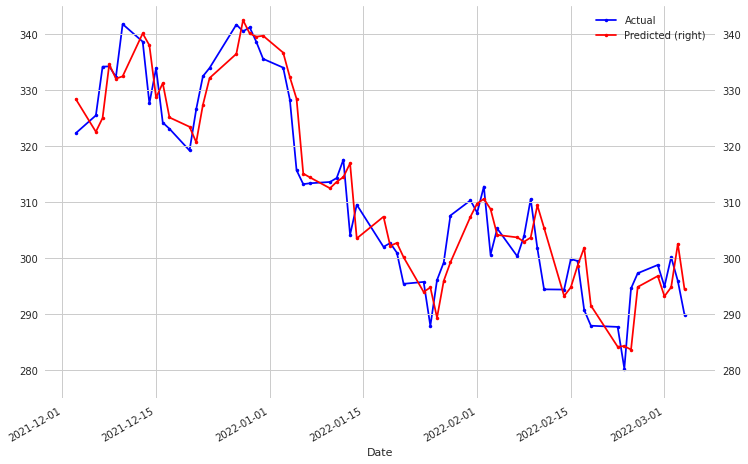

In [24]:
plt.figure(figsize=(12,8))

ax1 = df["5. adjusted close"][-63:].plot(color='blue', grid=True, secondary_y=False, label='Actual', marker='.')
ax2 = df["preds"][-63:].plot(color='red', grid=True, secondary_y=True, label='Predicted', marker='.')

if ticker == "aapl":
    a, b = 155, 185
elif ticker == "amzn":
    a, b = 2700, 3550
elif ticker == "msft":
    a, b = 275, 345

ax1.set_ylim(a,b)
ax2.set_ylim(a,b)

h1, l1 = ax1.get_legend_handles_labels()
h2, l2 = ax2.get_legend_handles_labels()

ax1.set_xlabel("Date")
plt.legend(h1+h2, l1+l2, loc=1)
plt.show()

In [25]:
true = df["5. adjusted close"][-244:]
predicted = df["preds"][-244:]

def mae(y_true, predictions):
    y_true, predictions = np.array(y_true), np.array(predictions)
    return np.mean(np.abs(y_true - predictions))


print(mae(true, predicted))

3.016636646722445


In [26]:
df.tail()

,5. adjusted close,preds
date,,
2022-02-28,298.79,296.814574
2022-03-01,294.95,293.190758
2022-03-02,300.19,294.808744
2022-03-03,295.92,302.574684
2022-03-04,289.86,294.416050


In [27]:
df_compare = df[-244:].copy()

true = df_compare["5. adjusted close"][-244:]
predicted = df_compare["preds"][-244:]

In [28]:
from sklearn.metrics import mean_absolute_error

In [29]:
test_mae = mean_absolute_error(true.to_numpy(), predicted)
f'Test MAE: {test_mae:.4f}'

'Test MAE: 3.0166'

In [30]:
df_compare.head()

,5. adjusted close,preds
date,,
2021-03-18,228.854221,233.487700
2021-03-19,228.487213,230.083341
2021-03-22,234.081604,229.195928
2021-03-23,235.658746,233.837539
2021-03-24,233.555890,234.491442


In [31]:
df_compare.tail()

,5. adjusted close,preds
date,,
2022-02-28,298.79,296.814574
2022-03-01,294.95,293.190758
2022-03-02,300.19,294.808744
2022-03-03,295.92,302.574684
2022-03-04,289.86,294.416050


In [32]:
df_compare["percentage_change"] = df_compare['5. adjusted close'].pct_change()
df_compare["increase"] = df_compare["percentage_change"].apply(lambda x: 1 if x > 0 else 0)

In [33]:
df_compare["percentage_change"] = df_compare["percentage_change"].shift(-1)
df_compare["increase"] = df_compare["increase"].shift(-1)
df_compare["preds"] = df_compare["preds"].shift(-1)

In [34]:
df_compare.head()

,5. adjusted close,preds,percentage_change,increase
date,,,,
2021-03-18,228.854221,230.083341,-0.001604,0.0
2021-03-19,228.487213,229.195928,0.024484,1.0
2021-03-22,234.081604,233.837539,0.006738,1.0
2021-03-23,235.658746,234.491442,-0.008923,0.0
2021-03-24,233.555890,234.617832,-0.013251,0.0


In [35]:
df_compare.tail()

,5. adjusted close,preds,percentage_change,increase
date,,,,
2022-02-28,298.79,293.190758,-0.012852,0.0
2022-03-01,294.95,294.808744,0.017766,1.0
2022-03-02,300.19,302.574684,-0.014224,0.0
2022-03-03,295.92,294.416050,-0.020479,0.0
2022-03-04,289.86,NaN,NaN,NaN


In [36]:
df_compare["pred_increase"] = np.where(df_compare["preds"] > df_compare["5. adjusted close"], 1.0, 0.0)

In [37]:
df_compare.head()

,5. adjusted close,preds,percentage_change,increase,pred_increase
date,,,,,
2021-03-18,228.854221,230.083341,-0.001604,0.0,1.0
2021-03-19,228.487213,229.195928,0.024484,1.0,1.0
2021-03-22,234.081604,233.837539,0.006738,1.0,0.0
2021-03-23,235.658746,234.491442,-0.008923,0.0,0.0
2021-03-24,233.555890,234.617832,-0.013251,0.0,1.0


In [38]:
df_compare.tail()

,5. adjusted close,preds,percentage_change,increase,pred_increase
date,,,,,
2022-02-28,298.79,293.190758,-0.012852,0.0,0.0
2022-03-01,294.95,294.808744,0.017766,1.0,0.0
2022-03-02,300.19,302.574684,-0.014224,0.0,1.0
2022-03-03,295.92,294.416050,-0.020479,0.0,0.0
2022-03-04,289.86,NaN,NaN,NaN,0.0


In [39]:
df_compare = df_compare.drop("2022-03-04")

#### Postive Increase Prediction %

In [40]:
df_compare[(df_compare["increase"]==1) & (df_compare["pred_increase"]==1)].shape[0] / df_compare[(df_compare["increase"]==1)].shape[0]

0.5476190476190477

### Negative Increase Prediction %

In [41]:
df_compare[(df_compare["increase"]==0) & (df_compare["pred_increase"]==0)].shape[0] / df_compare[(df_compare["increase"]==0)].shape[0]

0.5641025641025641

#### Overall Prediction Accuracy %

In [42]:
df_compare[(df_compare["increase"] == df_compare["pred_increase"])].shape[0] / (df_compare.shape[0])

0.5555555555555556

#### Actual Distribution of Increase (1) vs. Decrease (0)

In [43]:
df_compare["increase"].value_counts()

1.0    126
0.0    117
Name: increase, dtype: int64

In [44]:
df_compare["increase"].value_counts(normalize=True)

1.0    0.518519
0.0    0.481481
Name: increase, dtype: float64

### Predicted Distribution of Increase (1) vs. Decrease (0)

In [45]:
df_compare["pred_increase"].value_counts()

0.0    123
1.0    120
Name: pred_increase, dtype: int64

In [46]:
df_compare["pred_increase"].value_counts(normalize=True)

0.0    0.506173
1.0    0.493827
Name: pred_increase, dtype: float64

In [47]:
from sklearn.metrics import confusion_matrix, classification_report

In [48]:
class_names = ["Down", "Up"]

In [53]:
print(classification_report(df_compare["increase"], df_compare["pred_increase"], target_names=class_names, digits=4))

              precision    recall  f1-score   support

        Down     0.5366    0.5641    0.5500       117
          Up     0.5750    0.5476    0.5610       126

    accuracy                         0.5556       243
   macro avg     0.5558    0.5559    0.5555       243
weighted avg     0.5565    0.5556    0.5557       243



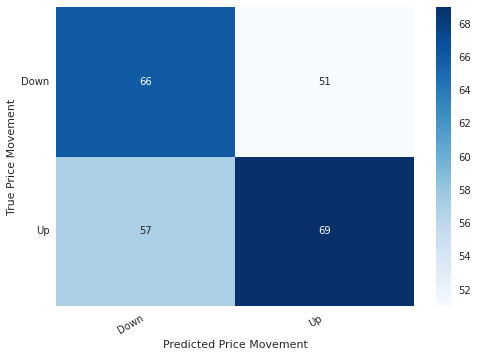

In [51]:
def plot_confusion_matrix(confusion_matrix):
  hm = sns.heatmap(confusion_matrix, annot=True, fmt="d", cmap="Blues")
  hm.yaxis.set_ticklabels(hm.yaxis.get_ticklabels(), rotation=0, ha='right')
  hm.xaxis.set_ticklabels(hm.xaxis.get_ticklabels(), rotation=30, ha='right')
  plt.ylabel('True Price Movement')
  plt.xlabel('Predicted Price Movement');


cm = confusion_matrix(df_compare["increase"], df_compare["pred_increase"])
df_ = pd.DataFrame(cm, index=class_names, columns=class_names)
plot_confusion_matrix(df_)